# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
# write all imports here
import os
import torch
from torchvision import datasets, transforms, models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from glob import glob

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline      

from tqdm import tqdm

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


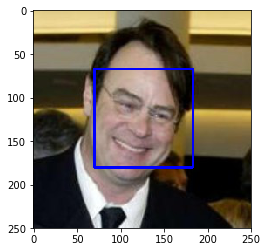

In [21]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [22]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    #read the image
    img = cv2.imread(img_path)
    #convert the BGR image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #detect face 
    faces = face_cascade.detectMultiScale(gray)
    #return True if human face exists
    return len(faces) > 0

In [23]:
face_detector('test/me.jpeg')

True

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

**98%** of first 100 images in `human_files` have detected human face 

**17%** of first 100 images in `dog_files` have detected human face

In [5]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
found_1 = 0
for img_path in human_files_short:
    if(face_detector(img_path)):
        found_1+=1

found_2 = 0
for img_path in dog_files_short:
    if(face_detector(img_path)):
        found_2+=1
        
print('Human face detected in human files: {:.2f}%'.format(found_1/len(human_files_short)*100))
print('Human face detected in dog files: {:.2f}%'.format(found_2/len(dog_files_short)*100))

Human face detected in human files: 98.00%
Human face detected in dog files: 17.00%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [3]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [19]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:08<00:00, 62576331.10it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [17]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    # display the image
    img = cv2.imread(img_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    pil_img = Image.open(img_path)
    loader = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()
    ])
    img = loader(pil_img)
    img.unsqueeze_(0)
    if(use_cuda):
        img = img.cuda()
    output = VGG16(img)
    _, preds = torch.max(output,1)
    
    
    return preds # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [24]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    pred_idx = VGG16_predict(img_path)
    #print('VGG16 predicted class index',pred_idx)
    if(pred_idx>=151 and pred_idx<=268):
        return True
    else:
        return False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

**0%** of first 100 images in `human_files` have detected dog face 

**76%** of first 100 images in `dog_files` have detected dog face

Dog face detected in human files: 1.00%
Dog face detected in dog files: 83.00%


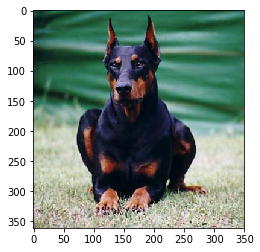

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

found_1 = 0
for img_path in human_files_short:
    if(dog_detector(img_path)):
        found_1+=1

found_2 = 0
for img_path in dog_files_short:
    if(dog_detector(img_path)):
        found_2+=1
        
print('Dog face detected in human files: {:.2f}%'.format(found_1/len(human_files_short)*100))
print('Dog face detected in dog files: {:.2f}%'.format(found_2/len(dog_files_short)*100))

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [5]:

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
batch_size = 32

data_root = {
    'train': '/data/dog_images/train',
    'valid': '/data/dog_images/valid',
    'test': '/data/dog_images/test'
}


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
      ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
}

img_datasets = {x: datasets.ImageFolder(data_root[x], data_transforms[x]) for x in ['train','valid','test']}

data_loaders = {x: torch.utils.data.DataLoader(img_datasets[x],batch_size=batch_size,shuffle=True) for x in ['train','valid','test']}

dataset_sizes = {x: len(img_datasets[x]) for x in ['train','valid','test']}
classes = img_datasets['train'].classes

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

1) I have cropped the image to size 224x224 by using `RandomResizedCrop()` for train dataloader and for valid dataloader I decided to use a `CenterCrop()`. Most of the pretrained models take 224x224 size images as input so I kept it the same way for CNN from scratch part and also normalization as is required by pretrained models. 

2) First I did not apply data augmentation and built my CNN from scratch and tried training but I never got accuracy above 1% even after changing other parameters like learning rate. After applying augmentation my accuracy increased. I have rotated images by 45deg and also applied horizontal flip. I choose 45deg because I wanted the images to be slightly titled, neither too much nor too little like by 20deg.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [5]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        ## convolutional layer sees 224x224x3 image tensor
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        ## convolutional layer sees 112x112x3 image tensor
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        ## convolutional layer sees  56X56x3 image tensor
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        ## convolutional layer sees  28X28x3 image tensor
        self.conv4 = nn.Conv2d(64,128,3,padding=1)
        ## convolutional layer sees  14X14x3 image tensor
        self.conv5 = nn.Conv2d(128,256,3,padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.fc1 = nn.Linear(7*7*256,4096)
        self.fc2 = nn.Linear(4096,512)
        self.fc3 = nn.Linear(512,133)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        
        #print(x.shape)
        #flatten the image input 
        x = x.view(-1, 7*7*256)
        
        #add a dropout layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=12544, out_features=4096, bias=True)
  (fc2): Li

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
1) 2 conv layer + 1 linear layer. Very bad accuarcy. Like no decrease in training loss at all

2) Increase conv layers and added max pooling layer after each conv layer. Tried with 3 conv + 2 fc layer. 

3) Then again added one more conv layer and fc layer. But accuracy was not high enough to cross 10%

4) Since I had increased the numbers of layers in network. I also added dropout of 0.25 to try and improve accuracy

Till here I had not applied image augmentation. Now I applied image augmentation and also read about batch normalization.

5) With same arch in Step 4) + image augmentation + batch normalization. The accuarcy reached 18% with 35 epcohs

6) Training for 50 epochs the accurcy reached 28%

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [ ]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(),lr=0.03,momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            
            # 1.clear all gradients
            optimizer.zero_grad()
            # 2.Forward Pass
            output = model(data)
            # 3.Calculate Loss
            loss = criterion(output,target)
            # 4.Backward pass
            loss.backward()
            # 5.Optimization step
            optimizer.step()
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output,target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('SAVE MODEL \n Validation Loss Decreased{:.6f}->{:.6f}'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(),save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model


In [9]:
n_epochs = 50
# train the model
model_scratch = train(n_epochs, data_loaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.807864 	Validation Loss: 4.570700
SAVE MODEL 
 Validation Loss Decreasedinf->4.570700
Epoch: 2 	Training Loss: 4.682255 	Validation Loss: 4.687647
Epoch: 3 	Training Loss: 4.608634 	Validation Loss: 4.462261
SAVE MODEL 
 Validation Loss Decreased4.570700->4.462261
Epoch: 4 	Training Loss: 4.551040 	Validation Loss: 4.688740
Epoch: 5 	Training Loss: 4.467935 	Validation Loss: 4.367352
SAVE MODEL 
 Validation Loss Decreased4.462261->4.367352
Epoch: 6 	Training Loss: 4.387055 	Validation Loss: 4.254793
SAVE MODEL 
 Validation Loss Decreased4.367352->4.254793
Epoch: 7 	Training Loss: 4.331546 	Validation Loss: 4.141040
SAVE MODEL 
 Validation Loss Decreased4.254793->4.141040
Epoch: 8 	Training Loss: 4.267070 	Validation Loss: 4.010479
SAVE MODEL 
 Validation Loss Decreased4.141040->4.010479
Epoch: 9 	Training Loss: 4.223013 	Validation Loss: 3.988127
SAVE MODEL 
 Validation Loss Decreased4.010479->3.988127
Epoch: 10 	Training Loss: 4.173136 	Validation Loss: 4.02

In [12]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [7]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [13]:
# call test function    
test(data_loaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.907567


Test Accuracy: 28% (236/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
# USING THE SAME DATA LOADERS AS ABOVE

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [8]:
## TODO: Specify model architecture 
model_transfer = models.densenet161(pretrained=True)
for param in model_transfer.parameters():
    param.requires_grad_(False)
    
model_transfer.classifier = nn.Linear(2208,133)
print(model_transfer)

if use_cuda:
    model_transfer = model_transfer.cuda()

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:04<00:00, 27051387.00it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ First I chose Resnet152 because it had the least Top-1 error as mentioned in pytorch [docs](https://pytorch.org/docs/stable/torchvision/models.html) . Also I simply just changed the last fully connected layer to have 133 output classes. The accuracy reached around 75% with only 10 epochs. After training for 5 more epochs the accuracy still remained the same.

So i decided to explore another pretrained model Densenet161, which I wanted to try since Phase 1.So after training the network for 15 epochs I was able to achieve a accuracy of 79%



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [9]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(),lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [10]:
# train the model
n_epochs = 15
model_transfer = train(n_epochs, data_loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 2.751493 	Validation Loss: 1.106280
SAVE MODEL 
 Validation Loss Decreasedinf->1.106280
Epoch: 2 	Training Loss: 1.256064 	Validation Loss: 0.661089
SAVE MODEL 
 Validation Loss Decreased1.106280->0.661089
Epoch: 3 	Training Loss: 1.001512 	Validation Loss: 0.535759
SAVE MODEL 
 Validation Loss Decreased0.661089->0.535759
Epoch: 4 	Training Loss: 0.865054 	Validation Loss: 0.485332
SAVE MODEL 
 Validation Loss Decreased0.535759->0.485332
Epoch: 5 	Training Loss: 0.806639 	Validation Loss: 0.482317
SAVE MODEL 
 Validation Loss Decreased0.485332->0.482317
Epoch: 6 	Training Loss: 0.726245 	Validation Loss: 0.387564
SAVE MODEL 
 Validation Loss Decreased0.482317->0.387564
Epoch: 7 	Training Loss: 0.688502 	Validation Loss: 0.339233
SAVE MODEL 
 Validation Loss Decreased0.387564->0.339233
Epoch: 8 	Training Loss: 0.673879 	Validation Loss: 0.373056
Epoch: 9 	Training Loss: 0.657730 	Validation Loss: 0.343404
Epoch: 10 	Training Loss: 0.643821 	Validation Loss: 0.36

In [27]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [11]:
test(data_loaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.728400


Test Accuracy: 79% (667/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [12]:
for idx,item in enumerate(classes[:10]):
    print(idx,item[4:])

0 Affenpinscher
1 Afghan_hound
2 Airedale_terrier
3 Akita
4 Alaskan_malamute
5 American_eskimo_dog
6 American_foxhound
7 American_staffordshire_terrier
8 American_water_spaniel
9 Anatolian_shepherd_dog


In [13]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in classes]

def predict_breed_transfer(img_path):
    
     # display the image
    img = cv2.imread(img_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    
    # load the image and return the predicted breed
    pil_img = Image.open(img_path).convert('RGB')
    loader = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    img = loader(pil_img)
    # add batch dimension
    img = img.unsqueeze_(0)
    
    model_transfer.eval()
    model_transfer.cpu()
    
    output = model_transfer(img)
    _, pred = torch.max(output,1)
    
    return class_names[pred.item()]

'Mastiff'

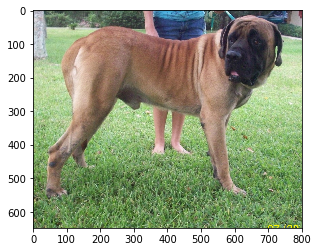

In [14]:
predict_breed_transfer(dog_files[0])

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [15]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    pred_class = predict_breed_transfer(img_path)
    print('Image Path:',img_path)
    #print('Dog',dog_detector(img_path))
    #print('Human',face_detector(img_path))
    if(dog_detector(img_path)):
        print('Hello, {}'.format(pred_class))
    elif(face_detector(img_path)):
        print('Hello human')
        print('You look like {}'.format(pred_class))
    else:
        print('Oops!! Couldn\'t detect anything')


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
1. Fine Tuning the model: I have not performed it here, as I did in phase 1 of scholarship because I had to devote a lot of time to CNN from scratch part. Fine tuning would further improve the accuracy by 2-4%
2. Reducing the batch_size to 16 I think would increase the accuracy
3. 

Image Path: /data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg
Hello human
You look like Great dane
Image Path: /data/lfw/Alex_Corretja/Alex_Corretja_0001.jpg
Hello human
You look like American foxhound
Image Path: /data/lfw/Daniele_Bergamin/Daniele_Bergamin_0001.jpg
Hello human
You look like Poodle
Image Path: /data/dog_images/train/103.Mastiff/Mastiff_06833.jpg
Hello, Mastiff
Image Path: /data/dog_images/train/103.Mastiff/Mastiff_06826.jpg
Hello, Mastiff
Image Path: /data/dog_images/train/103.Mastiff/Mastiff_06871.jpg
Hello, Mastiff


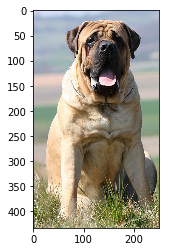

In [25]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

Image Path: test/tony_stark.jpg
Hello human
You look like Doberman pinscher
Image Path: test/Mastiff.jpg
Hello, Mastiff
Image Path: test/Yellow Labrador.jpg
Hello, Labrador retriever
Image Path: test/silky terrier.png
Hello, Silky terrier
Image Path: test/me.jpeg
Hello human
You look like Poodle


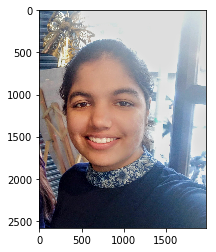

In [27]:
for file in os.listdir('test'):
    run_app('test/'+file)